# 프로젝트 : 주식 예측에 도전해 보자

### [루브릭]
1. 시계열의 안정성이 충분히 확인되었는가?
    - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
    
    
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
    
    
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    - 3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨 삼성전자, 카카오, SKT, Google 순으로 1.03%, 2.92%, 0.94%, 2.92%가 나왔다.
   - 신기하게도 카카오와 , google 같게 나왔다.. 


### [학습 과정]
1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기

### [결론 및 회고]

## 1. 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음.
* 우리는 Close만 사용할 예정. (주식 시장은 정해진 시간 동안만 거래가 가능함. 종가란 하루의 장이 마감하였을 때의 가격.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [2]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 원본 데이터 변수
    - `Date` : 날짜
    - `Open` : 시작가
    - `High` : 최고가
    - `Low` : 최저가
    - `Close` : 종가
    - `AdjClose` : 수정종가
    - `Volume` : 거래량
- 그 중 종가로만 가격을 분석해보자.

- 종가만 분리해 Series 형 데이터로 만든다.

In [3]:
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

정량적 ADF Test
- 귀무가설 : 해당 시계열이 안정적이지 않다.
- 대립가설 : 해당 시계열은 안정적이다.
- 통계적 가설 검정으로 귀무가설이 기각될 경우 대립가설을 채택한다.

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## Step 2 : 각종 전처리 수행

### 2-1. 결측치 처리
- 장이 열리지 않는 주말을 제외하고는 일정하게 하루에 한 가격씩이 모여 시계열을 이루고 있으므로 단순히 결측치를 제거해버리면 안된다.
- 시간을 기준으로 보간한다.

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


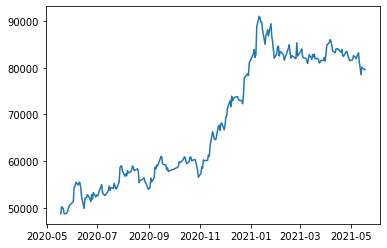

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

- 로그 변환 전

In [7]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 원 그래프와 이동평균, 이동표준편차 그래프 확인

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


### 2-2. 로그 변환
- 로그 변환을 시도해 원본 데이터와 로그 변환한 데이터 중 어느 쪽이 더 효과가 있는지 확인해보자

In [9]:
# 로그 변환 시도
ts_log = np.log(ts)

In [10]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 로그 변환 후
- 확실히 p-value가 작아지긴 했다.
- 귀무가설의 p-value가 0.5로 기각할 만큼 낮게 나오지는 않았다.

### 2-3. moving average 제거 - 추세 상쇄하기

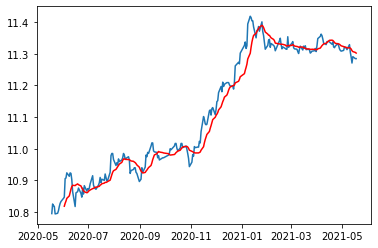

In [11]:
# Moving average 제거 - 추세 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [13]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

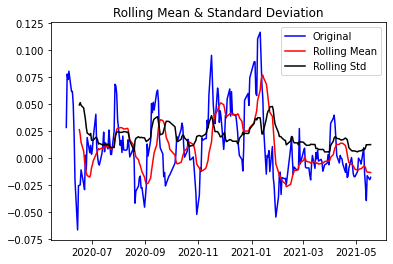

In [14]:
plot_rolling_statistics(ts_log_moving_avg)

In [15]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


### 2-4. 차분 - 계절성 상쇄하기

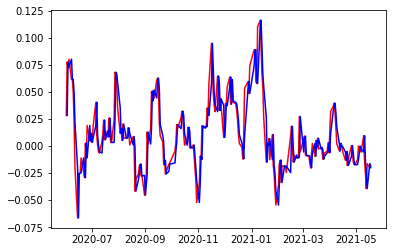

In [16]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='red')
plt.plot(ts_log_moving_avg_shift, color='blue')

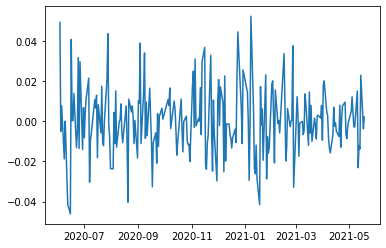

In [17]:
# 원본 시계열에서 시프트한 시계열 값을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

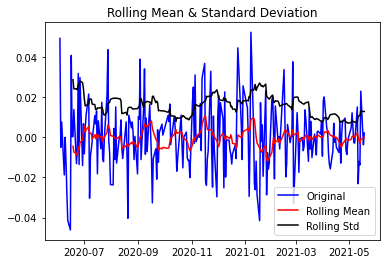

In [18]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [19]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


## Step 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- `statsmodels`의 `seasonal_decompose()`를 사용해 추세, 계절성을 제거해보자.

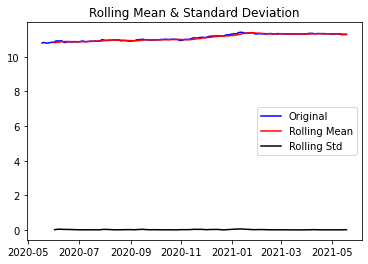

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


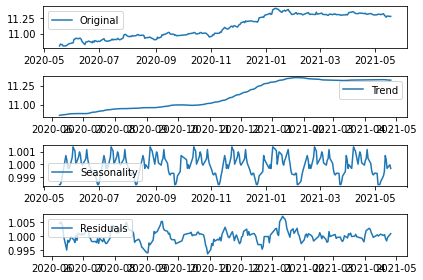

In [20]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [21]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## step4) train, test 데이터셋 생성

- 전체 데이터 : 2020-05~2021-05
- train_data : 2020-05~2021-04 
- test_data : 2021-04~2021-05

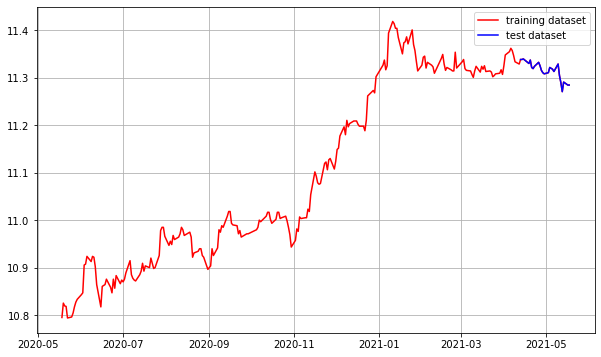

In [22]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

### 5-1. ACF, PACF 그려보기
- acf는 감소하는 추세를 보이고 있어 마땅한 q값이 없다.
- pacf는 1 이후에 급격히 0에 가까운 모습을 볼 수 있으니 p=1이 적절한 값이다.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


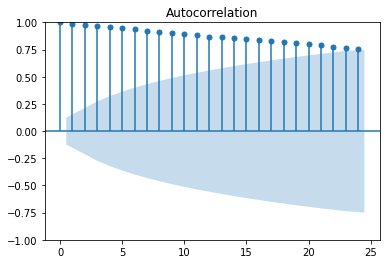

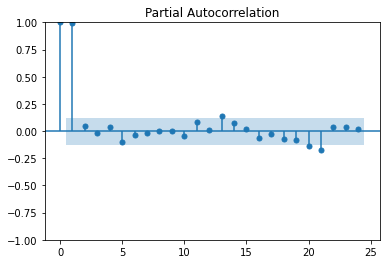

In [23]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 5-2. 차분 안정성 확인
- d 구하기
- 오히려 1차 차분했을 때의 p-value가 더 낮은 것을 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


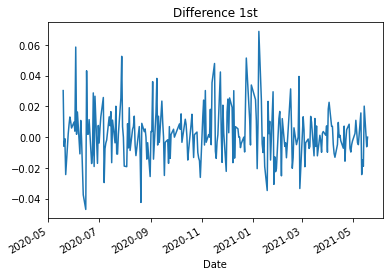

In [24]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


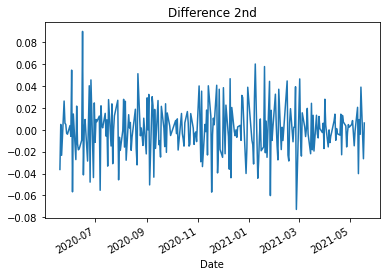

In [25]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## Step 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## 6-1. 모델 구성

- 앞서 그래프들을 통해 정한 대로 p = 2, q = 0, d = 1로 모델을 돌려 보자.

In [26]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        07:54:28   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## 6-2. 모델 예측 결과

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


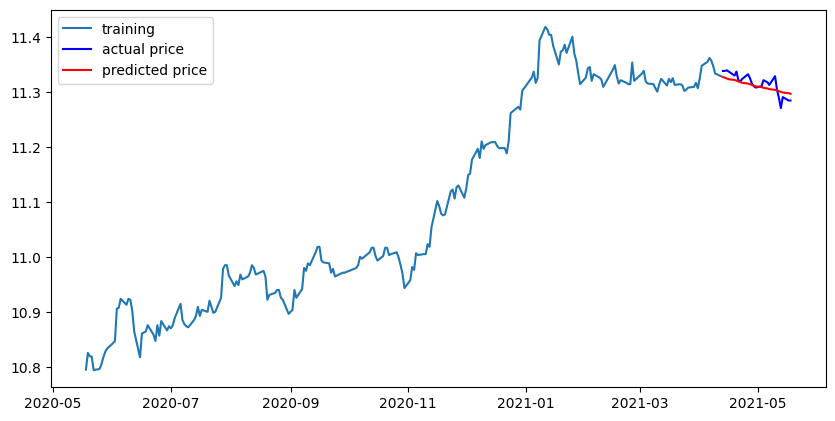

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


## 6-3. 모델 평가 지표

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# step7) 다른 주식 종목 예측해 보기

# 카카오 !

## 1. 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음.
* 우리는 Close만 사용할 예정. (주식 시장은 정해진 시간 동안만 거래가 가능함. 종가란 하루의 장이 마감하였을 때의 가격.)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [30]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,100800.0,103800.0,99900.0,102800.0,102752.000000,5380240
2021-02-17,103000.0,103000.0,100600.0,101800.0,101752.468750,2812860
2021-02-18,101200.0,103400.0,100200.0,100200.0,100153.210938,2334610
2021-02-19,99400.0,101200.0,98000.0,100800.0,100752.929688,3478320
2021-02-22,101000.0,102000.0,98000.0,98100.0,98054.195313,3204965


- 원본 데이터 변수
    - `Date` : 날짜
    - `Open` : 시작가
    - `High` : 최고가
    - `Low` : 최저가
    - `Close` : 종가
    - `AdjClose` : 수정종가
    - `Volume` : 거래량
- 그 중 종가로만 가격을 분석해보자.

- 종가만 분리해 Series 형 데이터로 만든다.

In [31]:
ts = df['Close']

ts.head()

Date
2021-02-16    102800.0
2021-02-17    101800.0
2021-02-18    100200.0
2021-02-19    100800.0
2021-02-22     98100.0
Name: Close, dtype: float64

정량적 ADF Test
- 귀무가설 : 해당 시계열이 안정적이지 않다.
- 대립가설 : 해당 시계열은 안정적이다.
- 통계적 가설 검정으로 귀무가설이 기각될 경우 대립가설을 채택한다.

In [32]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## Step 2 : 각종 전처리 수행

### 2-1. 결측치 처리
- 장이 열리지 않는 주말을 제외하고는 일정하게 하루에 한 가격씩이 모여 시계열을 이루고 있으므로 단순히 결측치를 제거해버리면 안된다.
- 시간을 기준으로 보간한다.

In [33]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


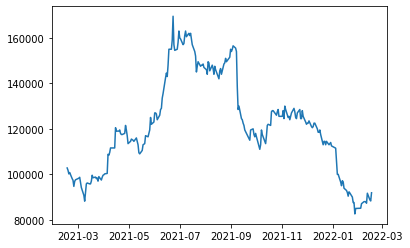

In [34]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

- 로그 변환 전

In [35]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.101701
p-value                          0.714393
#Lags Used                       3.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


- 원 그래프와 이동평균, 이동표준편차 그래프 확인

In [36]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


### 2-2. 로그 변환
- 로그 변환을 시도해 원본 데이터와 로그 변환한 데이터 중 어느 쪽이 더 효과가 있는지 확인해보자

In [37]:
# 로그 변환 시도
ts_log = np.log(ts)

In [38]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.585401
p-value                          0.490923
#Lags Used                       7.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


- 로그 변환 후
- 확실히 p-value가 작아지긴 했다.
- 귀무가설의 p-value가 0.5로 기각할 만큼 낮게 나오지는 않았다.

### 2-3. moving average 제거 - 추세 상쇄하기

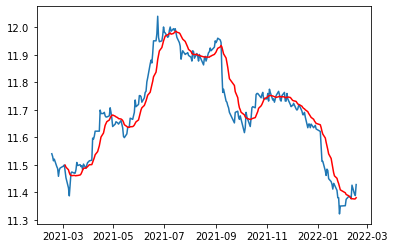

In [39]:
# Moving average 제거 - 추세 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [40]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
2021-03-02         NaN
2021-03-03         NaN
2021-03-04   -0.022727
2021-03-05   -0.038533
2021-03-08   -0.065765
2021-03-09   -0.084187
Name: Close, dtype: float64

In [41]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-03-04   -0.022727
2021-03-05   -0.038533
2021-03-08   -0.065765
2021-03-09   -0.084187
2021-03-10   -0.034393
2021-03-11    0.008059
2021-03-12    0.013258
2021-03-15    0.008129
2021-03-16    0.009081
2021-03-17    0.022043
2021-03-18    0.047399
2021-03-19    0.036463
2021-03-22    0.037454
2021-03-23    0.026963
2021-03-24    0.023318
Name: Close, dtype: float64

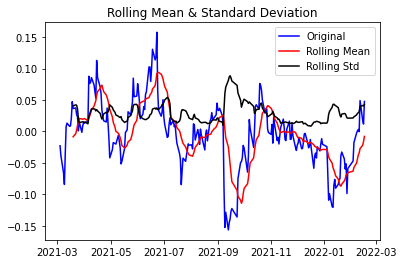

In [42]:
plot_rolling_statistics(ts_log_moving_avg)

In [43]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.542832
p-value                          0.006953
#Lags Used                       3.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


### 2-4. 차분 - 계절성 상쇄하기

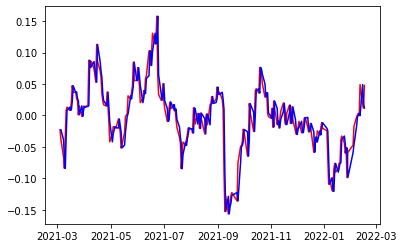

In [44]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='red')
plt.plot(ts_log_moving_avg_shift, color='blue')

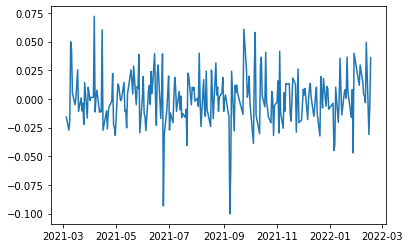

In [45]:
# 원본 시계열에서 시프트한 시계열 값을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

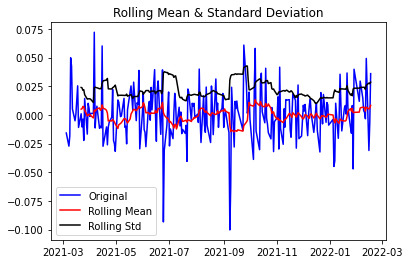

In [46]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [47]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -8.793943e+00
p-value                        2.202222e-14
#Lags Used                     2.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


## Step 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- `statsmodels`의 `seasonal_decompose()`를 사용해 추세, 계절성을 제거해보자.

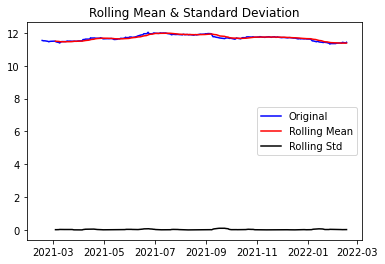

Results of Dickey-Fuller Test:
Test Statistic                  -1.585401
p-value                          0.490923
#Lags Used                       7.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


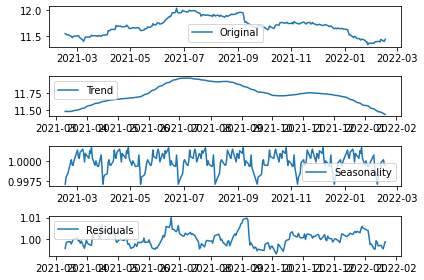

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [49]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.183838
p-value                          0.000702
#Lags Used                       3.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


## step4) train, test 데이터셋 생성

- 전체 데이터 : 2020-05~2021-05
- train_data : 2020-05~2021-04 
- test_data : 2021-04~2021-05

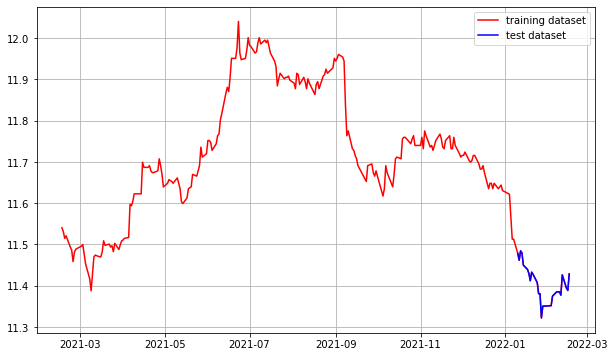

In [50]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

### 5-1. ACF, PACF 그려보기
- acf는 감소하는 추세를 보이고 있어 마땅한 q값이 없다.
- pacf는 1 이후에 급격히 0에 가까운 모습을 볼 수 있으니 p=1이 적절한 값이다.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


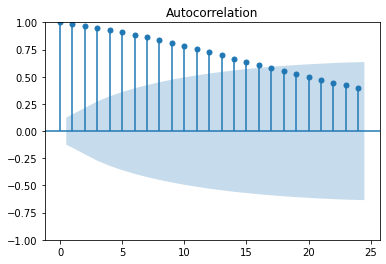

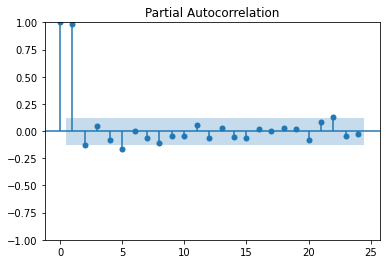

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 5-2. 차분 안정성 확인
- d 구하기
- 오히려 1차 차분했을 때의 p-value가 더 낮은 것을 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -6.567437e+00
p-value                        8.092623e-09
#Lags Used                     3.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


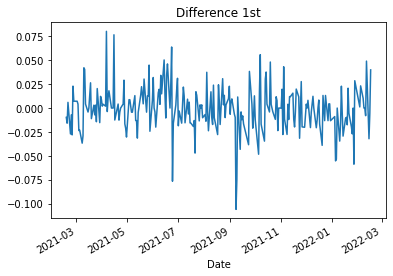

In [52]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.175071e+01
p-value                        1.211064e-21
#Lags Used                     5.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


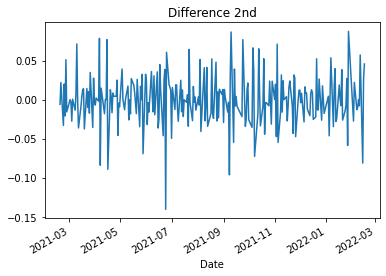

In [53]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## Step 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## 6-1. 모델 구성

- 앞서 그래프들을 통해 정한 대로 p = 1, q = 2, d = 1로 모델을 돌려 보자.

In [54]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 520.246
Date:                Thu, 17 Feb 2022   AIC                          -1032.492
Time:                        07:54:32   BIC                          -1018.881
Sample:                             0   HQIC                         -1026.996
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5542      0.396     -1.400      0.161      -1.330       0.222
ma.L1          0.6644      0.401      1.659      0.097      -0.121       1.449
ma.L2         -0.0413      0.114     -0.363      0.7

## 6-2. 모델 예측 결과

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


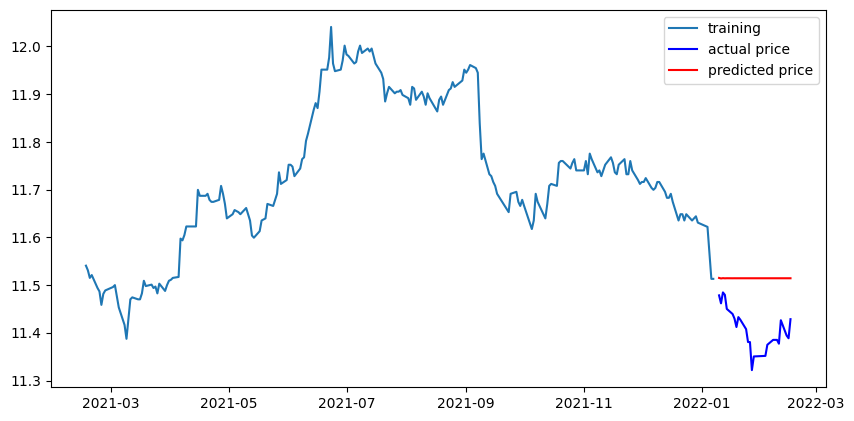

In [55]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


## 6-3. 모델 평가 지표

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  112037551.98540822
MAE:  9894.54777014718
RMSE:  10584.779260117248
MAPE: 11.16%


# SKT !

## 1. 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음.
* 우리는 Close만 사용할 예정. (주식 시장은 정해진 시간 동안만 거래가 가능함. 종가란 하루의 장이 마감하였을 때의 가격.)

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/017670.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

In [58]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,81335.351563,82652.523438,80841.406250,82652.523438,79171.804688,1168215
2021-02-17,82487.875000,83311.109375,81664.640625,83311.109375,79802.664063,1173089
2021-02-18,83805.046875,84792.921875,82981.812500,83311.109375,79802.664063,1262620
2021-02-19,83311.109375,83475.750000,81499.992188,83475.750000,79960.359375,945656
2021-02-22,83969.695313,83969.695313,81499.992188,81664.640625,78225.523438,1008843


- 원본 데이터 변수
    - `Date` : 날짜
    - `Open` : 시작가
    - `High` : 최고가
    - `Low` : 최저가
    - `Close` : 종가
    - `AdjClose` : 수정종가
    - `Volume` : 거래량
- 그 중 종가로만 가격을 분석해보자.

- 종가만 분리해 Series 형 데이터로 만든다.

In [59]:
ts = df['Close']

ts.head()

Date
2021-02-16    82652.523438
2021-02-17    83311.109375
2021-02-18    83311.109375
2021-02-19    83475.750000
2021-02-22    81664.640625
Name: Close, dtype: float64

정량적 ADF Test
- 귀무가설 : 해당 시계열이 안정적이지 않다.
- 대립가설 : 해당 시계열은 안정적이다.
- 통계적 가설 검정으로 귀무가설이 기각될 경우 대립가설을 채택한다.

In [60]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## Step 2 : 각종 전처리 수행

### 2-1. 결측치 처리
- 장이 열리지 않는 주말을 제외하고는 일정하게 하루에 한 가격씩이 모여 시계열을 이루고 있으므로 단순히 결측치를 제거해버리면 안된다.
- 시간을 기준으로 보간한다.

In [61]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


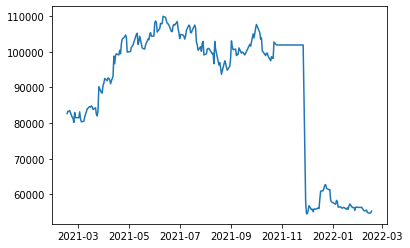

In [62]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

- 로그 변환 전

In [63]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.729052
p-value                          0.839080
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- 원 그래프와 이동평균, 이동표준편차 그래프 확인

In [64]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


### 2-2. 로그 변환
- 로그 변환을 시도해 원본 데이터와 로그 변환한 데이터 중 어느 쪽이 더 효과가 있는지 확인해보자

In [65]:
# 로그 변환 시도
ts_log = np.log(ts)

In [66]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.605176
p-value                          0.869808
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- 로그 변환 후
- 확실히 p-value가 작아지긴 했다.
- 귀무가설의 p-value가 0.5로 기각할 만큼 낮게 나오지는 않았다.

### 2-3. moving average 제거 - 추세 상쇄하기

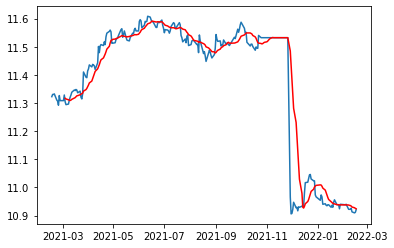

In [67]:
# Moving average 제거 - 추세 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [68]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
2021-03-02         NaN
2021-03-03         NaN
2021-03-04   -0.012351
2021-03-05   -0.020187
2021-03-08   -0.015293
2021-03-09    0.000584
Name: Close, dtype: float64

In [69]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-03-04   -0.012351
2021-03-05   -0.020187
2021-03-08   -0.015293
2021-03-09    0.000584
2021-03-10    0.011607
2021-03-11    0.018060
2021-03-12    0.025256
2021-03-15    0.028572
2021-03-16    0.025150
2021-03-17    0.025740
2021-03-18    0.020658
2021-03-19    0.010225
2021-03-22    0.012950
2021-03-23   -0.010959
2021-03-24   -0.018485
Name: Close, dtype: float64

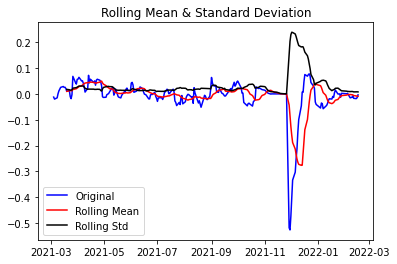

In [70]:
plot_rolling_statistics(ts_log_moving_avg)

In [71]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.403358
p-value                          0.000293
#Lags Used                       1.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


### 2-4. 차분 - 계절성 상쇄하기

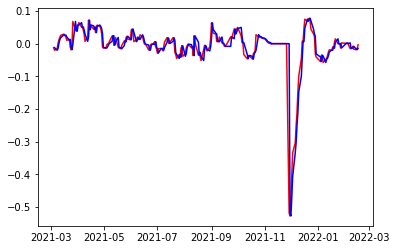

In [72]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='red')
plt.plot(ts_log_moving_avg_shift, color='blue')

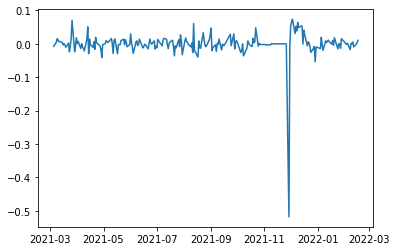

In [73]:
# 원본 시계열에서 시프트한 시계열 값을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

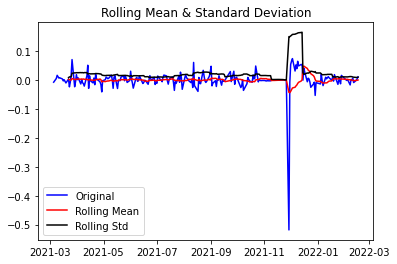

In [74]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [75]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.406915e+01
p-value                        2.961643e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


## Step 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- `statsmodels`의 `seasonal_decompose()`를 사용해 추세, 계절성을 제거해보자.

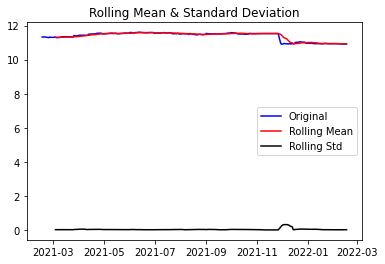

Results of Dickey-Fuller Test:
Test Statistic                  -0.605176
p-value                          0.869808
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


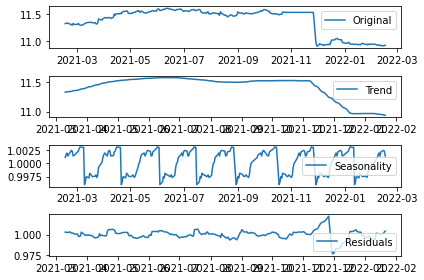

In [76]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [77]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.991955
p-value                          0.000023
#Lags Used                       1.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


## step4) train, test 데이터셋 생성

- 전체 데이터 : 2020-05~2021-05
- train_data : 2020-05~2021-04 
- test_data : 2021-04~2021-05

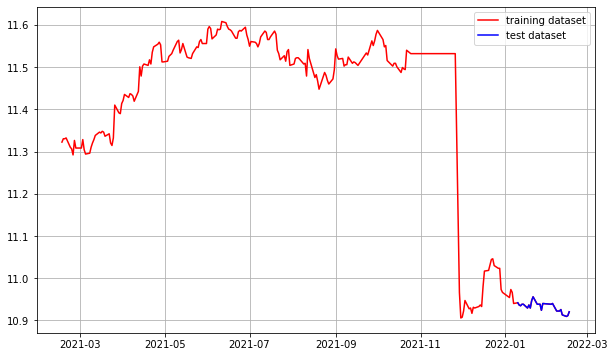

In [78]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

### 5-1. ACF, PACF 그려보기
- acf는 감소하는 추세를 보이고 있어 마땅한 q값이 없다.
- pacf는 1 이후에 급격히 0에 가까운 모습을 볼 수 있으니 p=1이 적절한 값이다.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


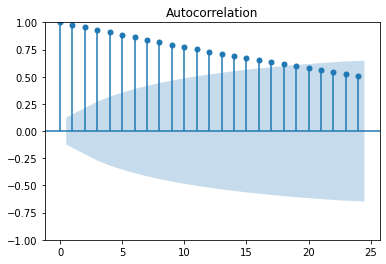

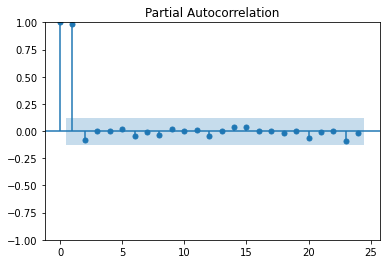

In [79]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 5-2. 차분 안정성 확인
- d 구하기
- 오히려 1차 차분했을 때의 p-value가 더 낮은 것을 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.442927e+01
p-value                        7.678768e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


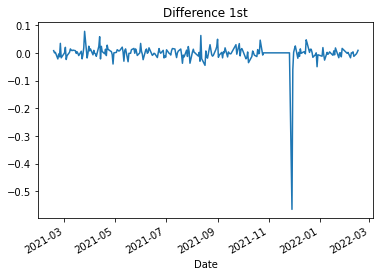

In [80]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.238182e+00
p-value                        5.813034e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


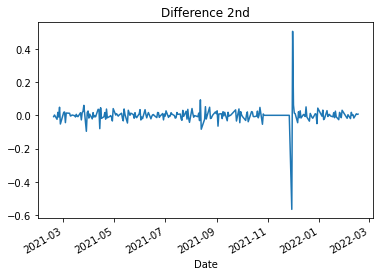

In [81]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## Step 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## 6-1. 모델 구성

- 앞서 그래프들을 통해 정한 대로 p = 1, q = 1, d = 1로 모델을 돌려 보자.

In [82]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 390.800
Date:                Thu, 17 Feb 2022   AIC                           -775.599
Time:                        07:54:35   BIC                           -765.391
Sample:                             0   HQIC                          -771.478
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1538      3.031     -0.051      0.960      -6.095       5.787
ma.L1          0.2392      2.989      0.080      0.936      -5.618       6.097
sigma2         0.0017   1.88e-05     92.060      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## 6-2. 모델 예측 결과

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


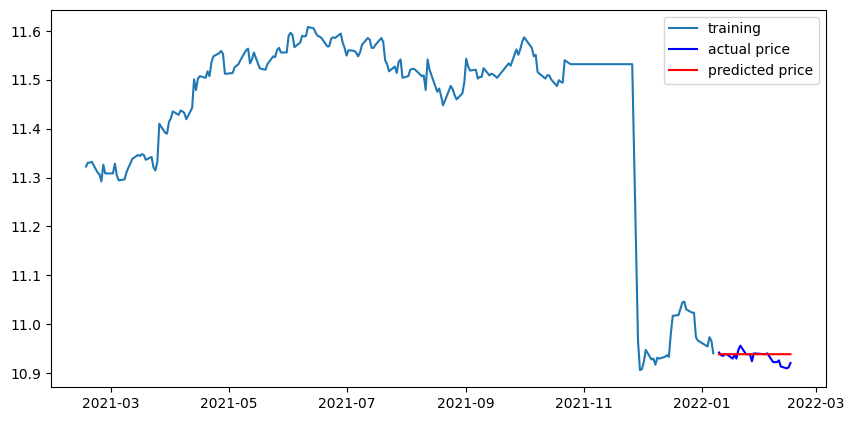

In [83]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


## 6-3. 모델 평가 지표

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  530271.2649465055
MAE:  522.3124790195521
RMSE:  728.1972706255534
MAPE: 0.94%


# Google !

## 1. 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음.
* 우리는 Close만 사용할 예정. (주식 시장은 정해진 시간 동안만 거래가 가능함. 종가란 하루의 장이 마감하였을 때의 가격.)

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)



In [86]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-16,2104.360107,2152.679932,2104.360107,2121.899902,2121.899902,1133800
2021-02-17,2100.000000,2133.659912,2098.919922,2128.310059,2128.310059,1070900
2021-02-18,2110.389893,2132.735107,2103.709961,2117.199951,2117.199951,1121600
2021-02-19,2119.270020,2130.530029,2097.409912,2101.139893,2101.139893,1457400
2021-02-22,2067.000000,2091.419922,2062.139893,2064.879883,2064.879883,1367500


- 원본 데이터 변수
    - `Date` : 날짜
    - `Open` : 시작가
    - `High` : 최고가
    - `Low` : 최저가
    - `Close` : 종가
    - `AdjClose` : 수정종가
    - `Volume` : 거래량
- 그 중 종가로만 가격을 분석해보자.

- 종가만 분리해 Series 형 데이터로 만든다.

In [87]:
ts = df['Close']

ts.head()

Date
2021-02-16    2121.899902
2021-02-17    2128.310059
2021-02-18    2117.199951
2021-02-19    2101.139893
2021-02-22    2064.879883
Name: Close, dtype: float64

정량적 ADF Test
- 귀무가설 : 해당 시계열이 안정적이지 않다.
- 대립가설 : 해당 시계열은 안정적이다.
- 통계적 가설 검정으로 귀무가설이 기각될 경우 대립가설을 채택한다.

In [88]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


## Step 2 : 각종 전처리 수행

### 2-1. 결측치 처리
- 장이 열리지 않는 주말을 제외하고는 일정하게 하루에 한 가격씩이 모여 시계열을 이루고 있으므로 단순히 결측치를 제거해버리면 안된다.
- 시간을 기준으로 보간한다.

In [89]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


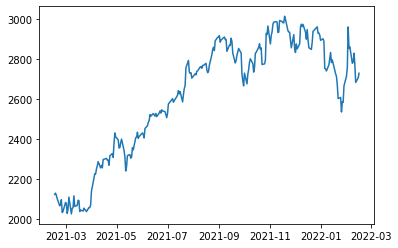

In [90]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

- 로그 변환 전

In [91]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.684744
p-value                          0.438989
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


- 원 그래프와 이동평균, 이동표준편차 그래프 확인

In [92]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


### 2-2. 로그 변환
- 로그 변환을 시도해 원본 데이터와 로그 변환한 데이터 중 어느 쪽이 더 효과가 있는지 확인해보자

In [93]:
# 로그 변환 시도
ts_log = np.log(ts)

In [94]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.690566
p-value                          0.435979
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


- 로그 변환 후
- 확실히 p-value가 작아지긴 했다.
- 귀무가설의 p-value가 0.5로 기각할 만큼 낮게 나오지는 않았다.

### 2-3. moving average 제거 - 추세 상쇄하기

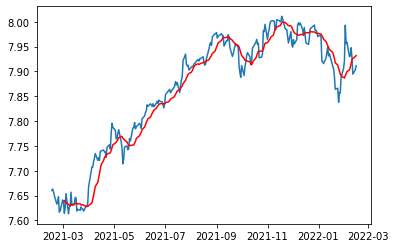

In [95]:
# Moving average 제거 - 추세 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [96]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
2021-03-01         NaN
2021-03-02         NaN
2021-03-03   -0.025492
2021-03-04   -0.011601
2021-03-05    0.017777
2021-03-08   -0.019314
Name: Close, dtype: float64

In [97]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-03-03   -0.025492
2021-03-04   -0.011601
2021-03-05    0.017777
2021-03-08   -0.019314
2021-03-09   -0.003375
2021-03-10   -0.001842
2021-03-11    0.025066
2021-03-12    0.001090
2021-03-15    0.001875
2021-03-16    0.012146
2021-03-17    0.011076
2021-03-18   -0.013904
2021-03-19   -0.011157
2021-03-22   -0.012988
2021-03-23   -0.003738
Name: Close, dtype: float64

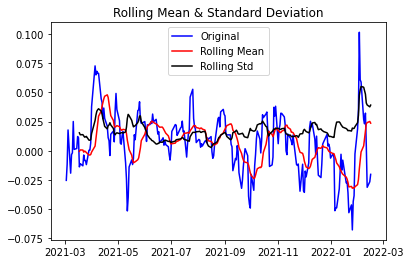

In [98]:
plot_rolling_statistics(ts_log_moving_avg)

In [99]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -5.483310
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


### 2-4. 차분 - 계절성 상쇄하기

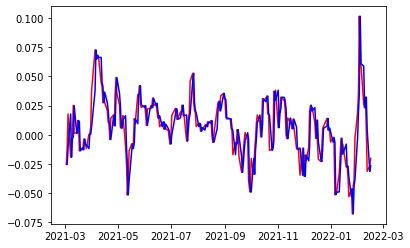

In [100]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='red')
plt.plot(ts_log_moving_avg_shift, color='blue')

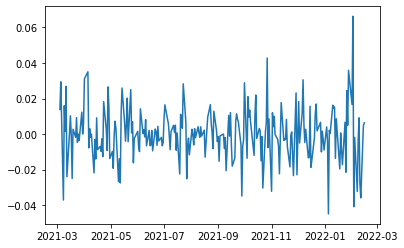

In [101]:
# 원본 시계열에서 시프트한 시계열 값을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

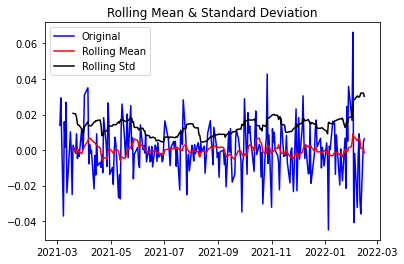

In [102]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [103]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.793932e+00
p-value                        7.808387e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


## Step 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

- `statsmodels`의 `seasonal_decompose()`를 사용해 추세, 계절성을 제거해보자.

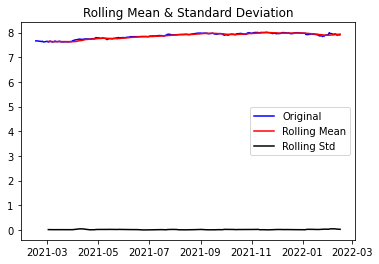

Results of Dickey-Fuller Test:
Test Statistic                  -1.690566
p-value                          0.435979
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


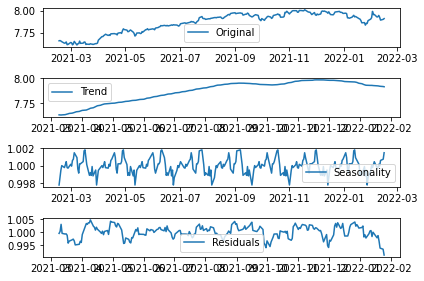

In [104]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [105]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.880864
p-value                          0.000038
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


## step4) train, test 데이터셋 생성

- 전체 데이터 : 2020-05~2021-05
- train_data : 2020-05~2021-04 
- test_data : 2021-04~2021-05

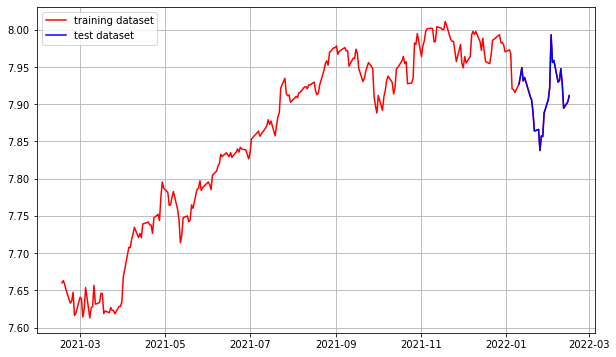

In [106]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

### 5-1. ACF, PACF 그려보기
- acf는 감소하는 추세를 보이고 있어 마땅한 q값이 없다.
- pacf는 1 이후에 급격히 0에 가까운 모습을 볼 수 있으니 p=1이 적절한 값이다.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


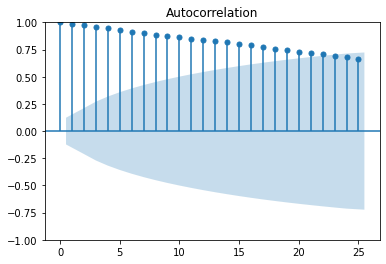

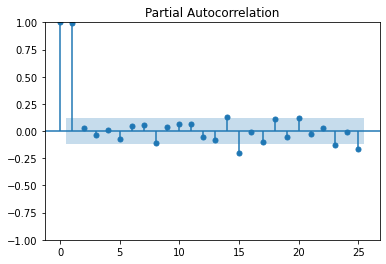

In [107]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 5-2. 차분 안정성 확인
- d 구하기
- 오히려 1차 차분했을 때의 p-value가 더 낮은 것을 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.640013e+01
p-value                        2.643079e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


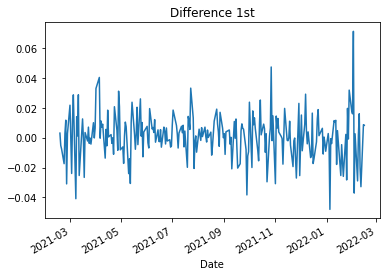

In [108]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.560726e+00
p-value                        8.710152e-14
#Lags Used                     1.400000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


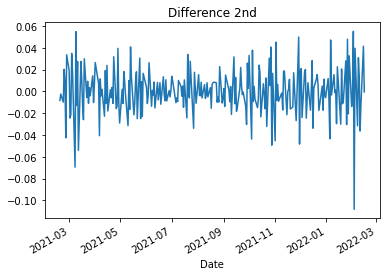

In [109]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# Step 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## 6-1. 모델 구성

- 앞서 그래프들을 통해 정한 대로 p = 1, q = 1, d = 1로 모델을 돌려 보자.

In [110]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 649.786
Date:                Thu, 17 Feb 2022   AIC                          -1293.572
Time:                        07:54:39   BIC                          -1283.297
Sample:                             0   HQIC                         -1289.426
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0101      3.417     -0.003      0.998      -6.707       6.687
ma.L1         -0.0101      3.417     -0.003      0.998      -6.708       6.688
sigma2         0.0002   1.41e-05     13.546      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

## 6-2. 모델 예측 결과

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


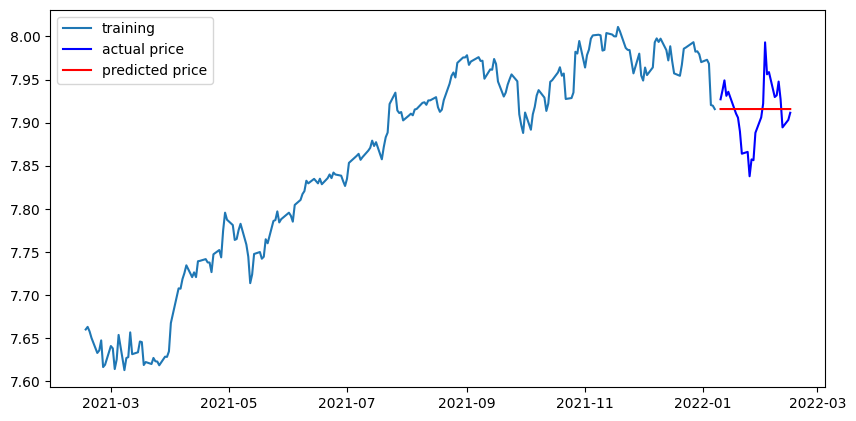

In [111]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


## 6-3. 모델 평가 지표

In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9664.895208406095
MAE:  79.30146743284844
RMSE:  98.3101989032984
MAPE: 2.92%


### [루브릭]
1. 시계열의 안정성이 충분히 확인되었는가?
    - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
    
    
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
    
    
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    - 3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨 삼성전자, 카카오, SKT, Google 순으로 1.03%, 2.92%, 0.94%, 2.92%가 나왔다.
   - 신기하게도 카카오와 , google 같게 나왔다.. 

# 결과 

- 주식 자료 모두 ACF와 PACF그래프를 보았을 때, 가시적으로 p값을 구하는 것이 더 효과적이 였고,
  공통적으로 2가 가장 적절한 값인 것 같았다, 
  따라서 곱해서 0이 되도록하는 q값(0)이나 곱해서 2보다 작게 만드는 값인 q값(1)을 위주로 
  모수를 선택했고, 0 ~ 2 에서 최적의 값을 찾아서 넣었다. MAPE는 10%이하로 떨어진 것을 볼 수 있다. 
  
  
## 참고 자료
[ARIMA](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)

##  회고는 마지막에.. 있습니다.. 스크롤압박이 너무 싫어서 시작하게된 번외편..

# 번외!! csv만 불러와서 바로 확인 할 수 없을까? 하면서 시작된 .. 작업

def `a(filename, stockname)` : 주가 csv 파일 기반으로 안정적인지 정성적, 정량적 테스트를 진행하고 train, test 데이터를 분리해 반환한다
- 위의 코드 처럼 일일히 작성 할 필요가 없다 !! 
- 이것은 순전히 스크롤 압박에서 벗어나고, 조금이나마 코드작성하는 번거로움을 덜어내고자 생각하게 되었다.

In [113]:
def a(filename, stockname):
    
    print(f'『Aiffel Ulsan 1st』┌( ￣∇￣)┘【 {stockname} 】┗(￣∇￣ )┓『Fighting ~ !!』')
    dataset_filepath = os.getenv('HOME') + f'/aiffel/stock_prediction/data/{filename}'
    
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    plt.plot(ts)
    plt.title("Original Data")
    plt.show()
    
        # 결측치 처리
    if ts.isna().sum():
        ts=ts.interpolate(method='time')
        plt.plot(ts)
        plt.title("After Interpolate")
        plt.show()
    
    # 로그 변환
    ts_log = np.log(ts)
    plt.plot(ts_log)
    plt.title("After Log")
    plt.show()

    # 정성적 그래프 분석
    print(f'{stockname} 종목 정성적 그래프 분석')
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    print(f'{stockname} 종목 정량적 ADF Test 분석')
    augmented_dickey_fuller_test(ts_log)

    # 시계열 분해
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    print(f'{stockname} 종목 시계열 분해')
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

    # 차분 안정성 확인
    print(f'{stockname} 차분 안정성 확인')
    
    print('====1차 차분====')
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    plt.show()
    augmented_dickey_fuller_test(diff_1)
    
    print('====2차 차분====')
    # 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')
    plt.show()
    augmented_dickey_fuller_test(diff_2)
    return train_data, test_data

In [114]:
def b(p, q, d, train_data, test_data):
    
    # 모델 생성
    # Build Model
    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit()  
    print(fitted_m.summary())
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()

    # 모델 지표
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

『Aiffel Ulsan 1st』┌( ￣∇￣)┘【 SK하이닉스 】┗(￣∇￣ )┓『Fighting ~ !!』


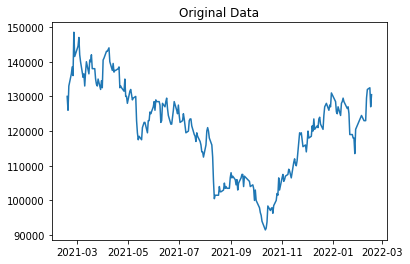

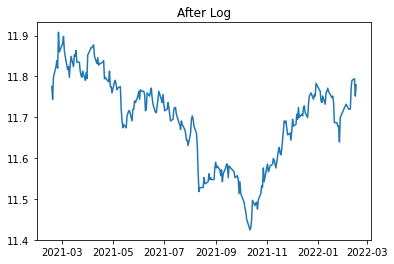

SK하이닉스 종목 정성적 그래프 분석


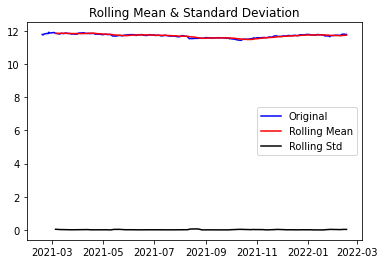

SK하이닉스 종목 정량적 ADF Test 분석
Results of Dickey-Fuller Test:
Test Statistic                  -1.599693
p-value                          0.483748
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64
SK하이닉스 종목 시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                  -5.526378
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


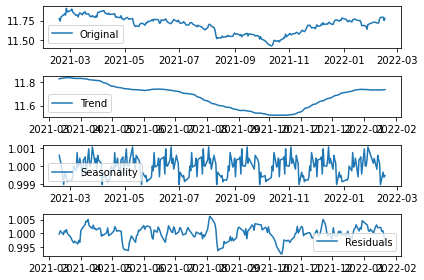

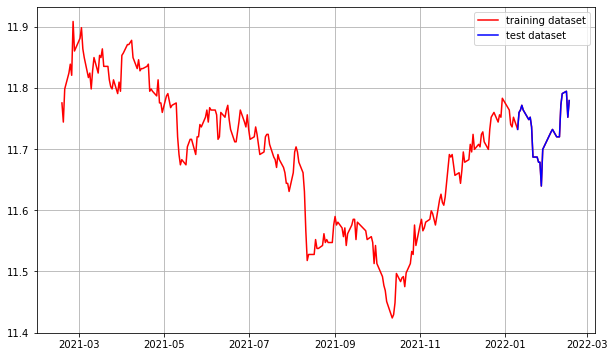

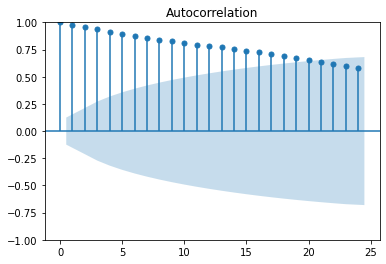

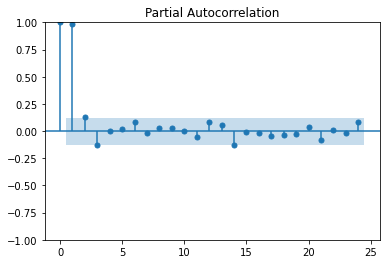

SK하이닉스 차분 안정성 확인
====1차 차분====


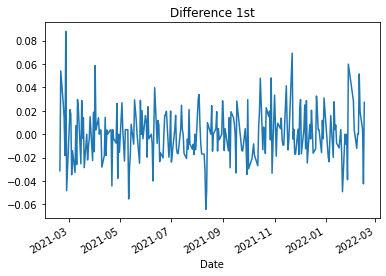

Results of Dickey-Fuller Test:
Test Statistic                -1.709308e+01
p-value                        7.567028e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
====2차 차분====


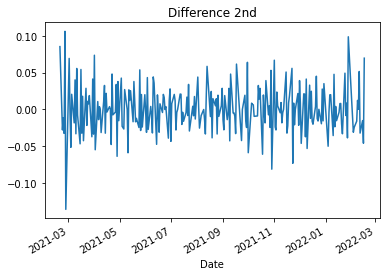

Results of Dickey-Fuller Test:
Test Statistic                -8.466614e+00
p-value                        1.516474e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [115]:
ka_train, ka_test = a('000660.KS.csv','SK하이닉스')

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 533.779
Date:                Thu, 17 Feb 2022   AIC                          -1063.559
Time:                        07:54:41   BIC                          -1056.763
Sample:                             0   HQIC                         -1060.815
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0971      0.058     -1.685      0.092      -0.210       0.016
sigma2         0.0005   3.55e-05     13.172      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

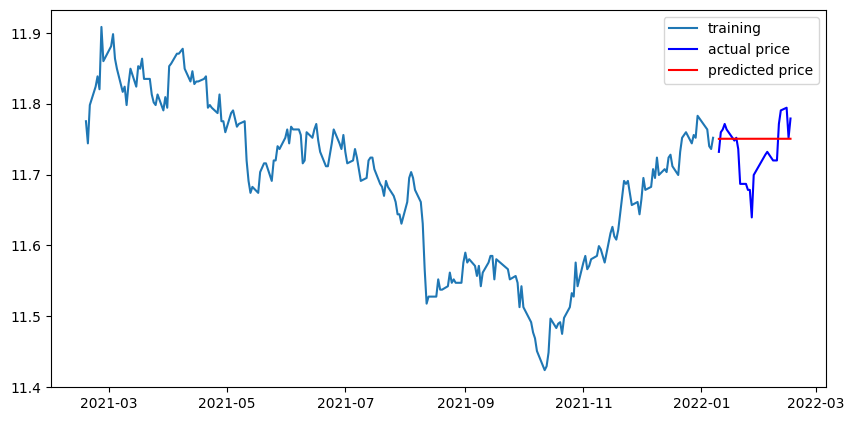

MSE:  26215290.273584515
MAE:  3957.849575604378
RMSE:  5120.086940041596
MAPE: 3.25%


In [116]:
b(1,0,1,ka_train, ka_test)

- 이렇게 했으면, 이제는 바로 csv 불러오기만 하면된다. 아래의 방법처럼

ka_train, ka_test = a('파일이름','주식이름')  <<<<<<<<<< 여기서 왜 a냐고 묻는 일은 없길 바란다.

b(p,d,q,ka_train, ka_test) <<<<<<<<<<<< p,d,q 는 직접 지정해줘야 한다. 여기서 왜 b라고 묻는 일은 없길 바란다.


# 회고
- 통계와 거리가 멀어서 생소한 개념들이 많았는데 이번 기회에 공부할 수 있었다.
- 전반적으로 ACF 그래프가 감소해도 p=1, q=1로 모델링 하는 게 MAPE가 더 낮았다.
- 조금 더 공부가 필요해 보인다.